# Dense sequences II

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from connectivity_functions import create_matrix_from_sequences_representation_aditive
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

## An example

In [2]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.01

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                  strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                  always_learning=always_learning, normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = np.copy(matrix)
seq[4] = matrix[2]
seq[5:] = matrix[4:-1]

n_connections = len(seq) - 1
nr = build_network_representation(matrix, minicolumns, hypercolumns)

value = 1.0
B = 1 - np.exp(-T_persistence / tau_a)
alpha = 2 * value
g_a = g_w_ampa * alpha / B
nn.g_a = g_a
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation_aditive(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10)

aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

nn.w_ampa = w
w_diff = 2 * alpha
current = 2  * g_w_ampa * w_diff
noise = factor * current
nn.sigma = noise

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 744 µs


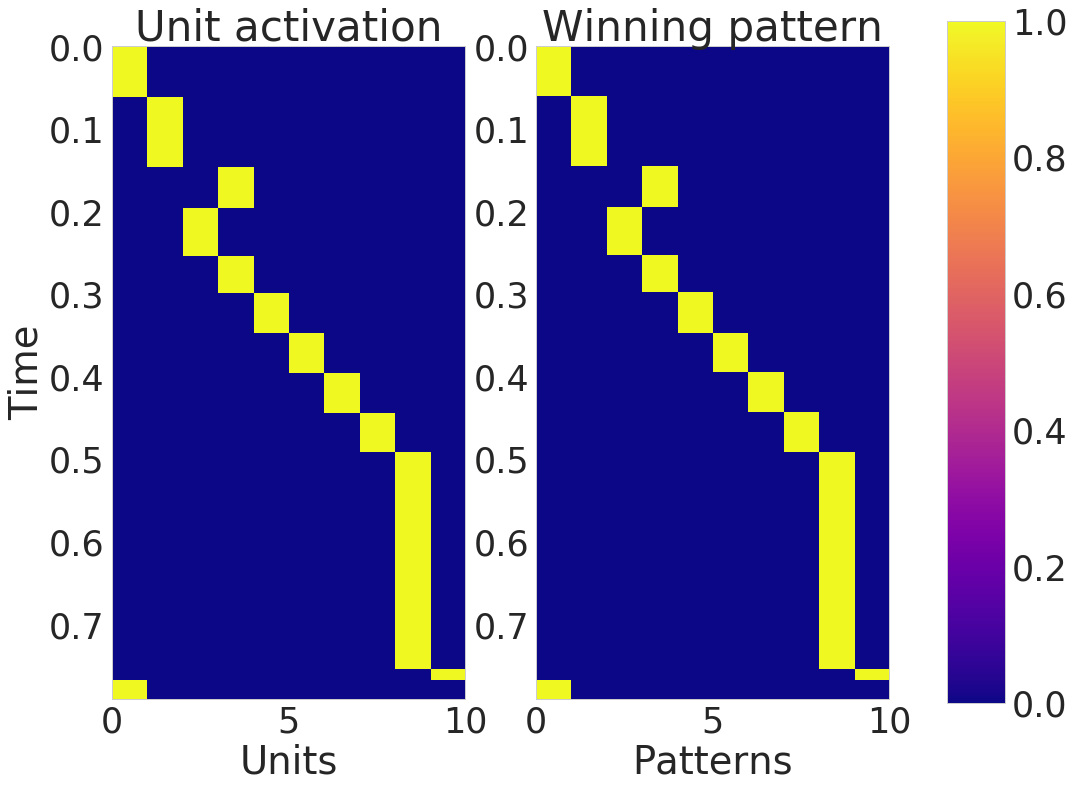

In [3]:
aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
plot_network_activity_angle(manager)

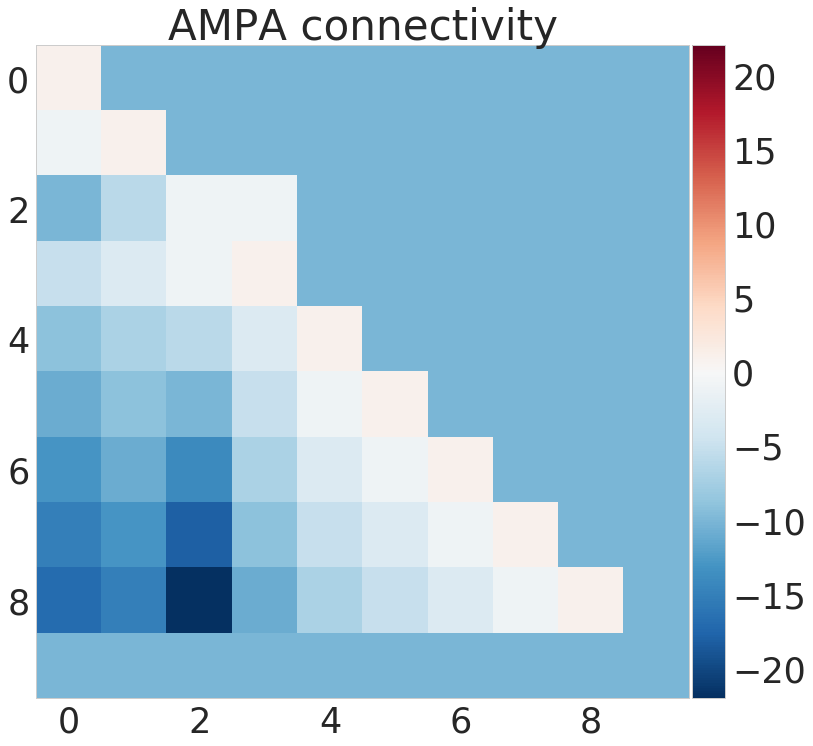

In [4]:
plot_weight_matrix(nn, ampa=True)

In [5]:
seq

array([[0],
       [1],
       [2],
       [3],
       [2],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [6]:
pattern_sequence

[0, 1, 3, 2, 3, 4, 5, 6, 7, 8, 9, 0]

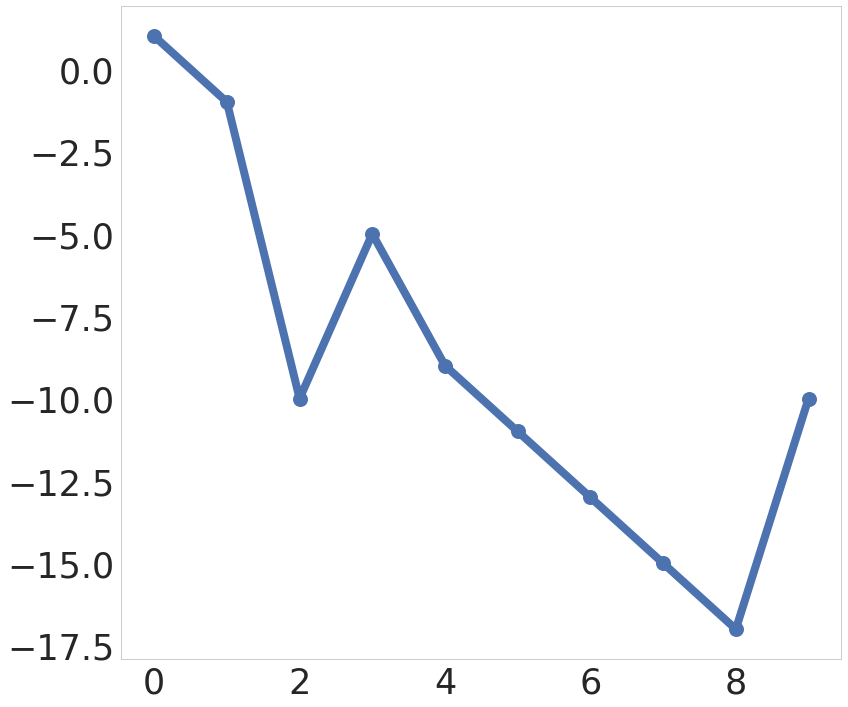

In [7]:
plt.plot(w[:, 0], 'o-', ms=15, lw=8)

## An example with training

In [8]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.00


# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, g_beta=g_beta,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
seq = np.copy(matrix)
seq[4] = matrix[2]
seq[5:] = matrix[4:-1]

nr = build_network_representation(seq, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)


nn.w_ampa = w
nn.beta = beta

# Fix the persistence time
B = 1 - np.exp(-T_persistence / tau_a)
w_per = w[1, 1] - w[2, 1]
g_a = g_w_ampa * w_per / B
nn.g_a = g_a

w_rob = w[1, 1] - w[3, 1]
current = 2  * g_w_ampa * w_rob
noise = factor * current
nn.sigma = noise

# Dictionary
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

[ -1.47705  -1.47698  -1.17595  -1.47698  -1.47698  -1.47698  -1.47698
  -1.47698  -1.47698 -79.     ]
[ -1.47705  -1.47698  -1.17595  -1.47698  -1.47698  -1.47698  -1.47698
  -1.47698  -1.47698 -79.     ]


1.0


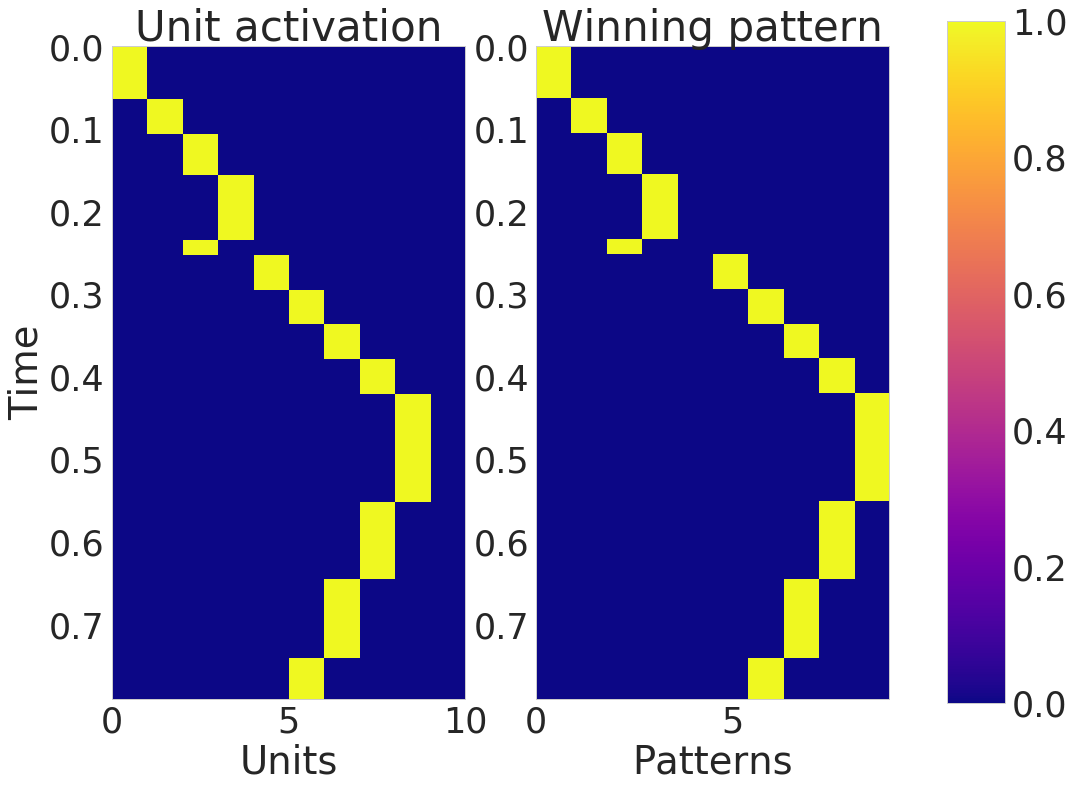

In [28]:
aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
print(s)
plot_network_activity_angle(manager)

In [11]:
seq

array([[0],
       [1],
       [2],
       [3],
       [2],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [12]:
pattern_sequence

[0, 1, 2, 3, 2, 5, 6, 7, 8, 9, 8, 7, 6]

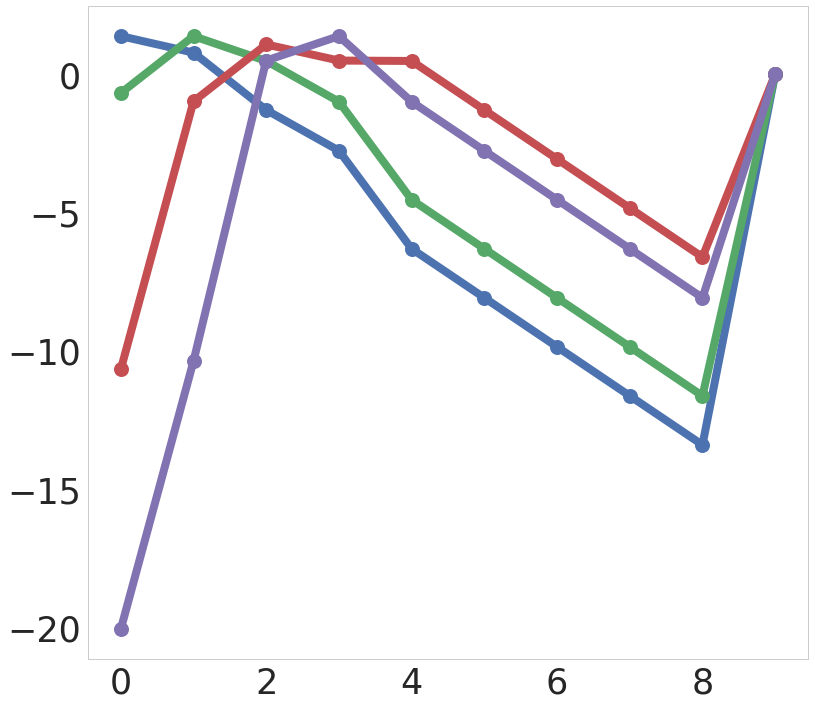

In [29]:
plt.plot(w[:, 0], 'o-', ms=15, lw=8)
plt.plot(w[:, 1], 'o-', ms=15, lw=8)
plt.plot(w[:, 2], 'o-', ms=15, lw=8)
plt.plot(w[:, 3], 'o-', ms=15, lw=8)

In [14]:
w[1, 1]

1.3744371230084433

In [15]:
w[3, 3]

1.3744371230084433

In [16]:
w[2, 2]

1.0743338043985184

In [21]:
patterns_dic

{0: array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 2: array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 3: array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 5: array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 6: array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 7: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 8: array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 9: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}

In [22]:
nr

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [23]:
seq

array([[0],
       [1],
       [2],
       [3],
       [2],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [26]:
np.unique(nr, axis=0, return_index=True, return_inverse=True)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([9, 8, 7, 6, 5, 3, 2, 1, 0]),
 array([8, 7, 6, 5, 6, 4, 3, 2, 1, 0]))

In [27]:
np.unique?